In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
import time

import sys
sys.path.append('../../')

from data.processing import get_data

import models

from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, forecast_all_trials, create_all_trials_csv, create_decile_csv_new
from main.seir.sensitivity import calculate_sensitivity_and_plot
from utils.generic.create_report import save_dict_and_create_report
from utils.generic.config import read_config
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
#from utils.generic.logging import log_wandb
from viz import plot_forecast, plot_top_k_trials, plot_ptiles

import yaml

In [31]:
predictions_dict = {}

In [32]:
config_filename = 'jharkhand.yaml'
config = read_config(config_filename)

In [33]:
output_folder = '../../misc/reports/{}'.format(datetime.datetime.now().strftime("%Y_%m%d_%H%M%S"))

## Perform M1 and M2 fits

Performing m1 fit ..
loading from ../../misc/cache/dataframes_ts_28092020_tracker.pkl
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 146                 | 147                 | 148                 | 149                 | 150                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-09-20 00:00:00 | 2020-09-21 00:00:00 | 2020-09-22 00:00:00 | 2020-09-23 00:00:00 | 2020-09-24 00:00:00 |
| state       | Jharkhand           | Jharkhand           | Jharkhand           | Jharkhand           | Jharkhand           |
| district    | Ranchi              | Ranchi              | Ranchi              | Ranchi              | Ranchi              |
| total       | 15568.86            | 15922.14            | 16083.33            | 16252.2             | 16388.5    

/home/ramkamal/anaconda3/envs/covid/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


100%|██████████| 1000/1000 [00:40<00:00, 24.58trial/s, best loss: 1.2984905589095925]
best parameters
 {'E_hosp_ratio': 0.7771334573549946, 'I_hosp_ratio': 0.12811276973494795, 'P_fatal': 0.007395209816056676, 'T_inc': 4.325169048077554, 'T_inf': 3.2543020770931226, 'T_recov': 10.614629709018526, 'T_recov_fatal': 18.725461520856395, 'lockdown_R0': 0.9648151900463374}
Performing m2 fit ..
loading from ../../misc/cache/dataframes_ts_28092020_tracker.pkl
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 149                 | 150                 | 151                 | 152                 | 153                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-09-23 00:00:00 | 2020-09-24 00:00:00 | 2020-09-25 00:00:00 | 2020-09-26 00:00:00 | 2020-09-27 00:00:00

/home/ramkamal/anaconda3/envs/covid/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


100%|██████████| 1000/1000 [00:40<00:00, 24.58trial/s, best loss: 0.9820973006752978]
best parameters
 {'E_hosp_ratio': 0.24658065379514307, 'I_hosp_ratio': 0.3778476221854797, 'P_fatal': 0.007792112941390856, 'T_inc': 4.322965043578357, 'T_inf': 3.6795176187354515, 'T_recov': 13.747419829453996, 'T_recov_fatal': 28.7533863897051, 'lockdown_R0': 1.571025513576198}


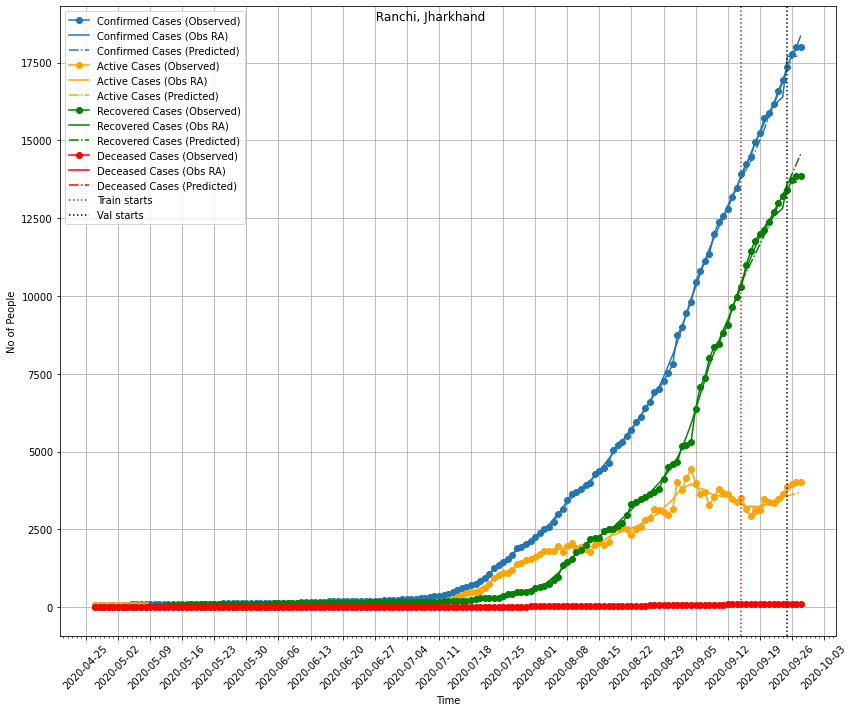

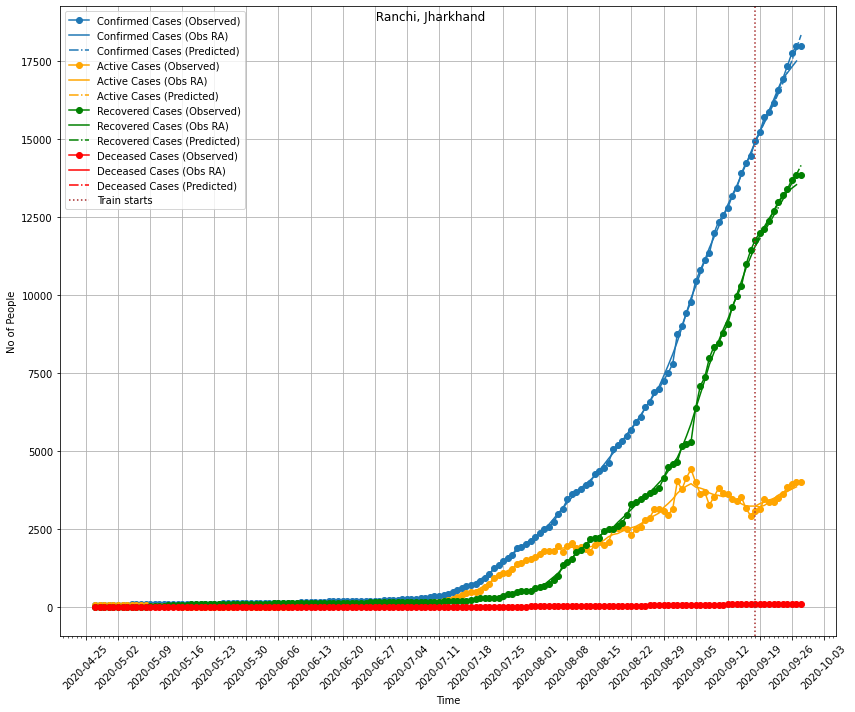

In [34]:
predictions_dict['m1'] = single_fitting_cycle(**copy.deepcopy(config['fitting'])) 

m2_params = copy.deepcopy(config['fitting'])
m2_params['split']['val_period'] = 0
predictions_dict['m2'] = single_fitting_cycle(**m2_params)

predictions_dict['fitting_date'] = datetime.datetime.now().strftime("%Y-%m-%d")

In [7]:
predictions_dict['m1']['best_params']

{'E_hosp_ratio': 0.5362427020948005,
 'I_hosp_ratio': 0.3071318982179755,
 'P_fatal': 0.00972693010107168,
 'T_inc': 4.553913455611021,
 'T_inf': 3.7274217541654275,
 'T_recov': 10.045207971707356,
 'T_recov_fatal': 35.001021892792,
 'lockdown_R0': 1.372302274712409}

In [8]:
predictions_dict['m2']['best_params']

{'E_hosp_ratio': 0.5436487461071289,
 'I_hosp_ratio': 0.24355089120562984,
 'P_fatal': 0.009620318835511107,
 'T_inc': 4.848412109289771,
 'T_inf': 3.2131219239782065,
 'T_recov': 12.48612999426167,
 'T_recov_fatal': 34.16277194590094,
 'lockdown_R0': 1.679812016748967}

## Loss Dataframes

### M1 Loss DataFrame

In [9]:
predictions_dict['m1']['df_loss']

,train,val
total,0.701943,2.03947
active,4.01857,3.55293
recovered,1.49419,3.65369
deceased,1.51597,1.91392


### M2 Loss DataFrame

In [10]:
predictions_dict['m2']['df_loss']

,train
total,0.563209
active,2.36696
recovered,0.803948
deceased,0.879833


## Sensitivity Plot

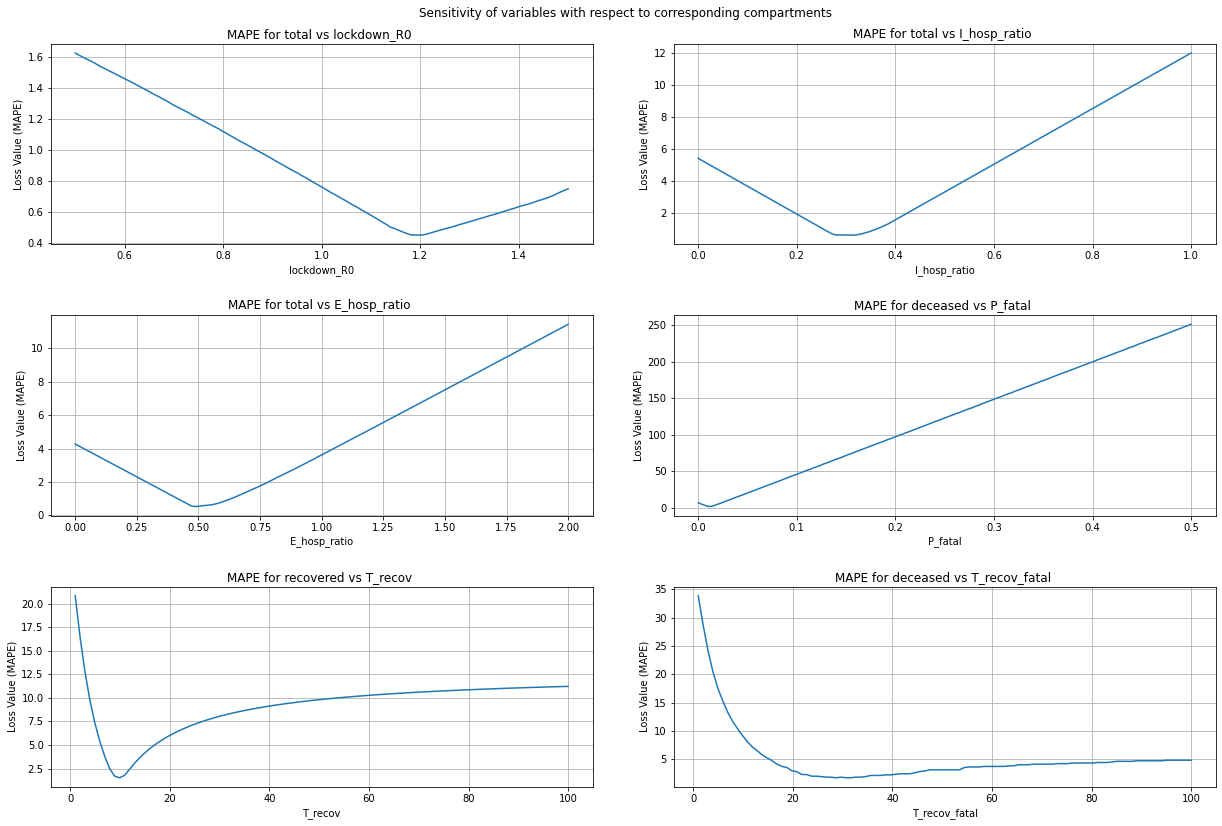

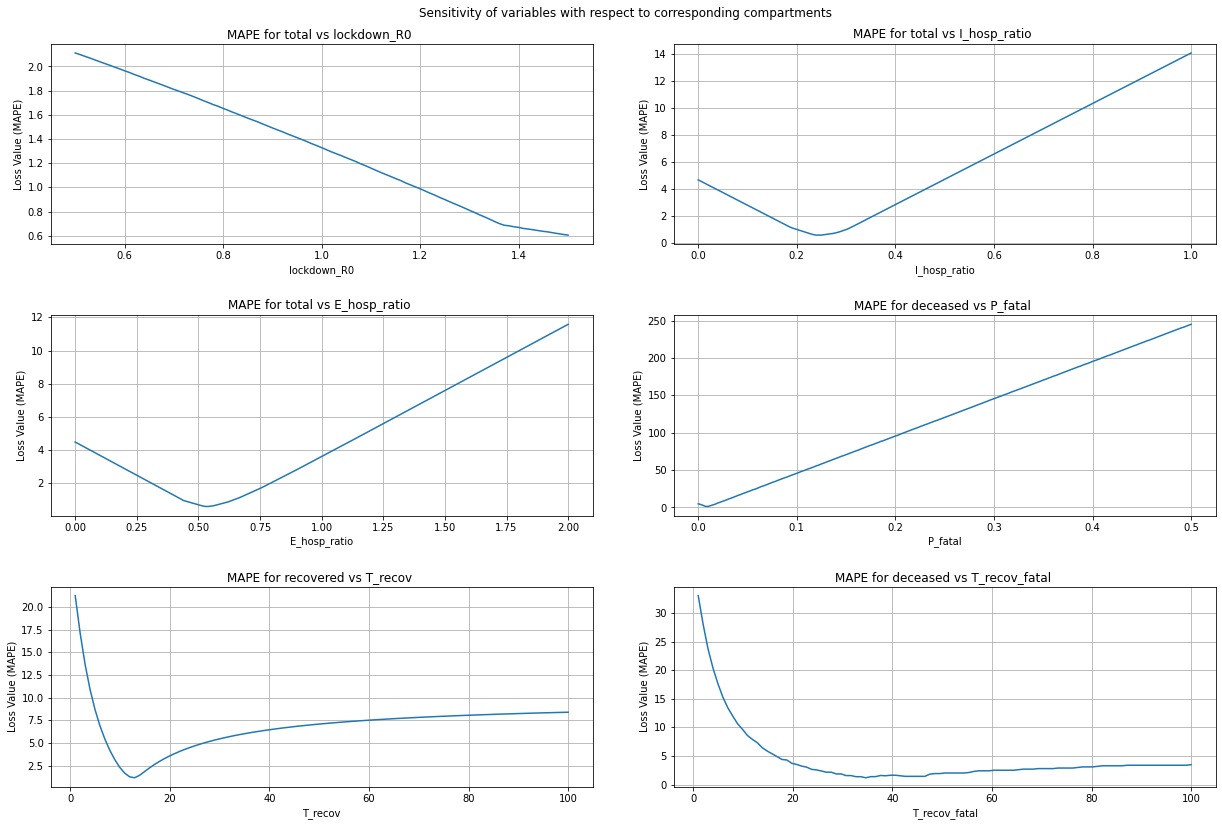

In [11]:
predictions_dict['m1']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m1')
predictions_dict['m2']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m2')

## Plot Forecasts

In [12]:
# M2 based forecasting for the next train_period + test_period + forecast_period (no validation period)
predictions_dict['m2']['forecasts'] = {}
predictions_dict['m2']['forecasts']['best'] = get_forecast(predictions_dict, train_fit='m2', 
                                                           model=config['fitting']['model'], 
                                                           days=config['forecast']['forecast_days'])

getting forecasts ..


[         date        S      E      I  R_recov  R_fatal       C    D  active  \
0  2020-09-18  1382530   1763    789     3211       31   11576   97    3242   
1  2020-09-19  1382094   1829    896     3215       32   11833   98    3247   
2  2020-09-20  1381607   1929    989     3247       34   12091   99    3281   
3  2020-09-21  1381074   2052   1078     3304       36   12353  100    3340   
4  2020-09-22  1380495   2193   1166     3382       38   12621  101    3420   
5  2020-09-23  1379870   2350   1257     3481       41   12896  102    3522   
6  2020-09-24  1379198   2520   1353     3600       44   13179  103    3644   
7  2020-09-25  1378475   2704   1455     3739       46   13473  104    3785   
8  2020-09-26  1377699   2903   1563     3898       50   13779  106    3948   
9  2020-09-27  1376865   3116   1679     4078       53   14098  107    4131   
10 2020-09-28  1375968   3345   1804     4281       56   14433  109    4337   
11 2020-09-29  1375007   3591   1937     4506      

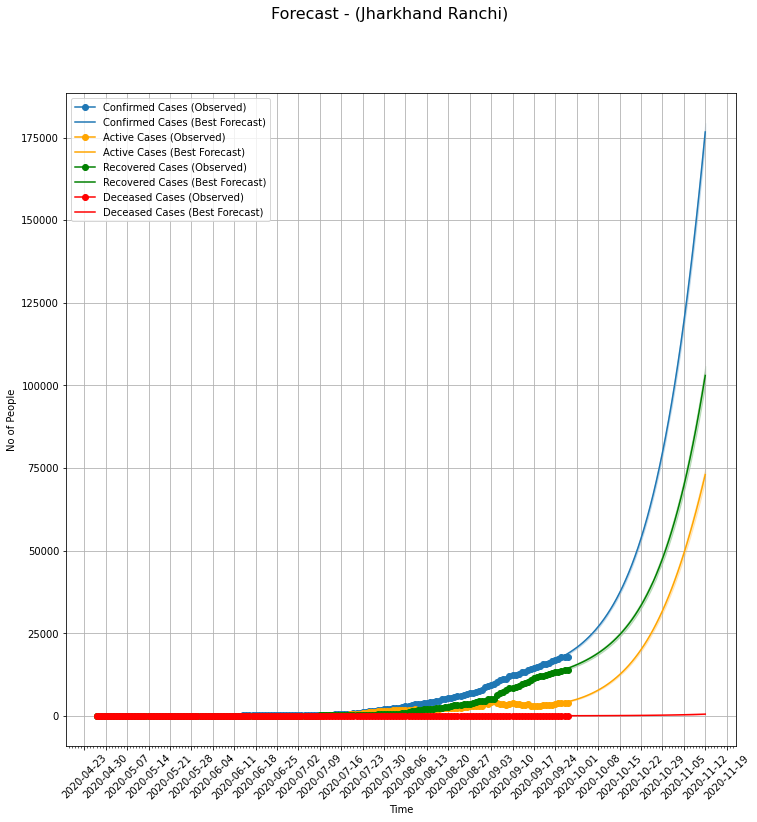

In [13]:
# Predictions plotted are for the most recent train_period days + test_period + forecast_period (no validation_period)
predictions_dict['m2']['plots']['forecast_best'] = plot_forecast(predictions_dict, 
                                                                 (config['fitting']['data']['dataloading_params']['state'], 
                                                                  config['fitting']['data']['dataloading_params']['district']), 
                                                                 error_bars=True)

In [14]:
predictions_dict['m1']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m1', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

12it [00:00, 112.73it/s]

getting forecasts ..


1000it [00:10, 95.35it/s]


In [15]:
predictions_dict['m2']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m2', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

9it [00:00, 83.97it/s]

getting forecasts ..


1000it [00:11, 90.15it/s]


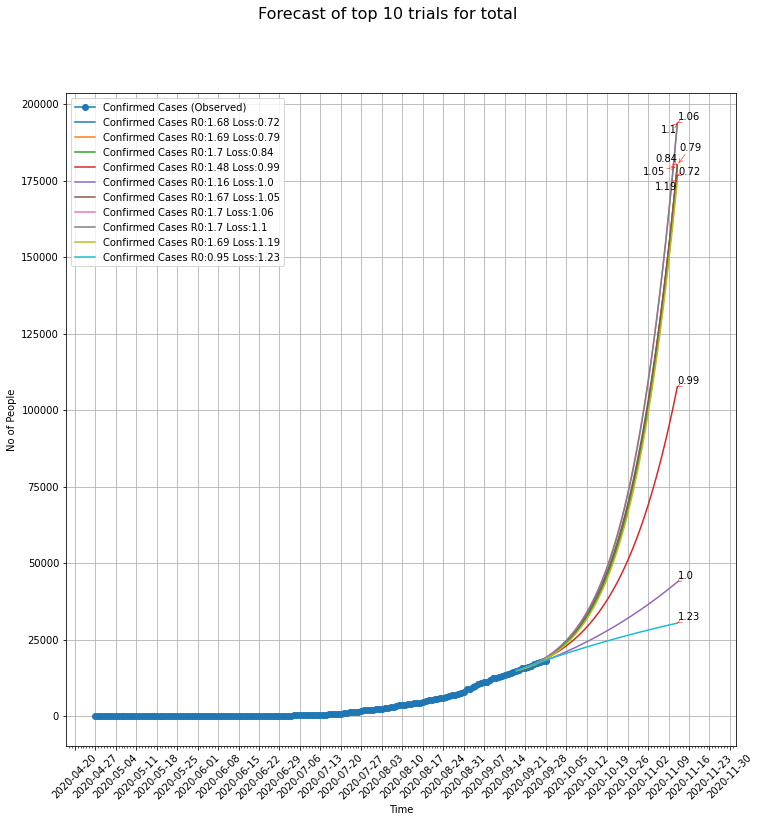

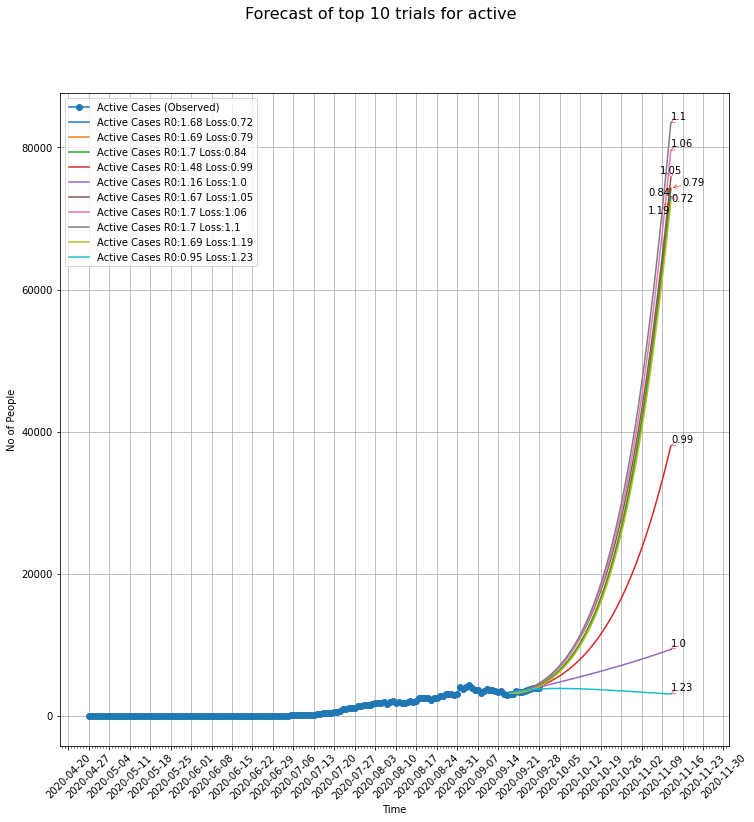

In [16]:
kforecasts = plot_top_k_trials(predictions_dict, train_fit='m2',
                               k=config['forecast']['num_trials_to_plot'],
                               which_compartments=config['forecast']['plot_topk_trials_for_columns'])

In [17]:
predictions_dict['m2']['plots']['forecasts_topk'] = {}
for column in config['forecast']['plot_topk_trials_for_columns']:
    predictions_dict['m2']['plots']['forecasts_topk'][column.name] = kforecasts[column]

## Uncertainty + Uncertainty Forecasts

In [18]:
uncertainty_args = {'predictions_dict': predictions_dict, **config['uncertainty']['uncertainty_params']}
uncertainty = config['uncertainty']['method'](**uncertainty_args)

100%|██████████| 100/100 [00:52<00:00,  1.92trial/s, best loss: 3.960322265014831]


In [19]:
uncertainty.beta_loss

{'active': 6.186882657326194,
 'recovered': 4.202300006450407,
 'deceased': 3.5659870063458707,
 'total': 1.8861193899368527}

In [20]:
uncertainty_forecasts = uncertainty.get_forecasts()
for key in uncertainty_forecasts.keys():
    predictions_dict['m2']['forecasts'][key] = uncertainty_forecasts[key]['df_prediction']
    
predictions_dict['m2']['forecasts']['ensemble_mean'] = uncertainty.ensemble_mean_forecast

In [21]:
predictions_dict['m2']['beta'] = uncertainty.beta
predictions_dict['m2']['beta_loss'] = uncertainty.beta_loss
predictions_dict['m2']['deciles'] = uncertainty_forecasts

[         date        S      E      I  R_recov  R_fatal       C    D  active  \
0  2020-09-18  1382530   1763    789     3211       31   11576   97    3242   
1  2020-09-19  1382094   1829    896     3215       32   11833   98    3247   
2  2020-09-20  1381607   1929    989     3247       34   12091   99    3281   
3  2020-09-21  1381074   2052   1078     3304       36   12353  100    3340   
4  2020-09-22  1380495   2193   1166     3382       38   12621  101    3420   
5  2020-09-23  1379870   2350   1257     3481       41   12896  102    3522   
6  2020-09-24  1379198   2520   1353     3600       44   13179  103    3644   
7  2020-09-25  1378475   2704   1455     3739       46   13473  104    3785   
8  2020-09-26  1377699   2903   1563     3898       50   13779  106    3948   
9  2020-09-27  1376865   3116   1679     4078       53   14098  107    4131   
10 2020-09-28  1375968   3345   1804     4281       56   14433  109    4337   
11 2020-09-29  1375007   3591   1937     4506      

[         date        S      E      I  R_recov  R_fatal       C    D  active  \
0  2020-09-18  1382530   1763    789     3211       31   11576   97    3242   
1  2020-09-19  1382094   1829    896     3215       32   11833   98    3247   
2  2020-09-20  1381607   1929    989     3247       34   12091   99    3281   
3  2020-09-21  1381074   2052   1078     3304       36   12353  100    3340   
4  2020-09-22  1380495   2193   1166     3382       38   12621  101    3420   
5  2020-09-23  1379870   2350   1257     3481       41   12896  102    3522   
6  2020-09-24  1379198   2520   1353     3600       44   13179  103    3644   
7  2020-09-25  1378475   2704   1455     3739       46   13473  104    3785   
8  2020-09-26  1377699   2903   1563     3898       50   13779  106    3948   
9  2020-09-27  1376865   3116   1679     4078       53   14098  107    4131   
10 2020-09-28  1375968   3345   1804     4281       56   14433  109    4337   
11 2020-09-29  1375007   3591   1937     4506      

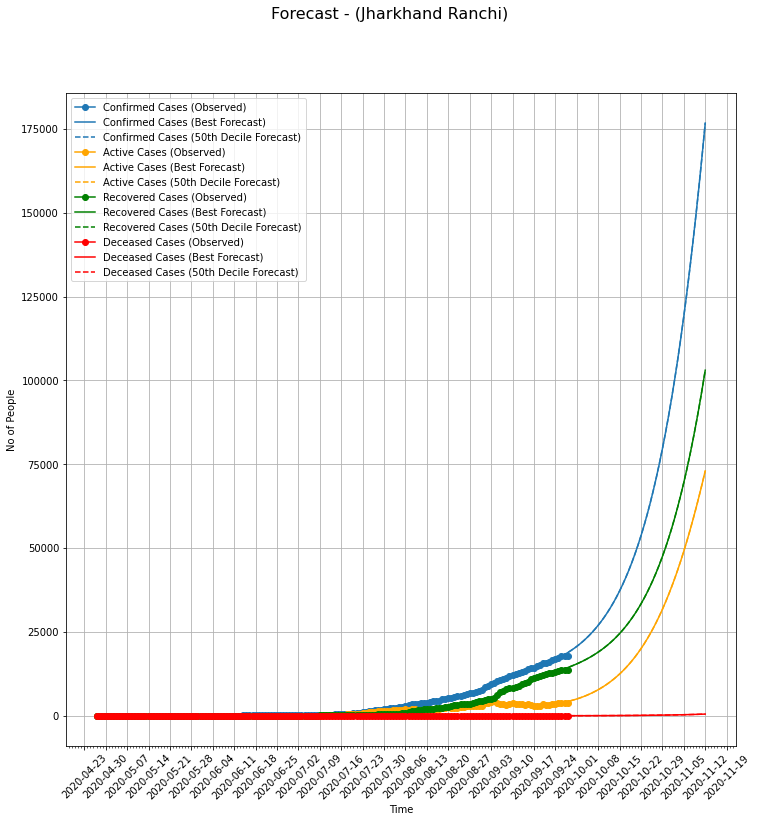

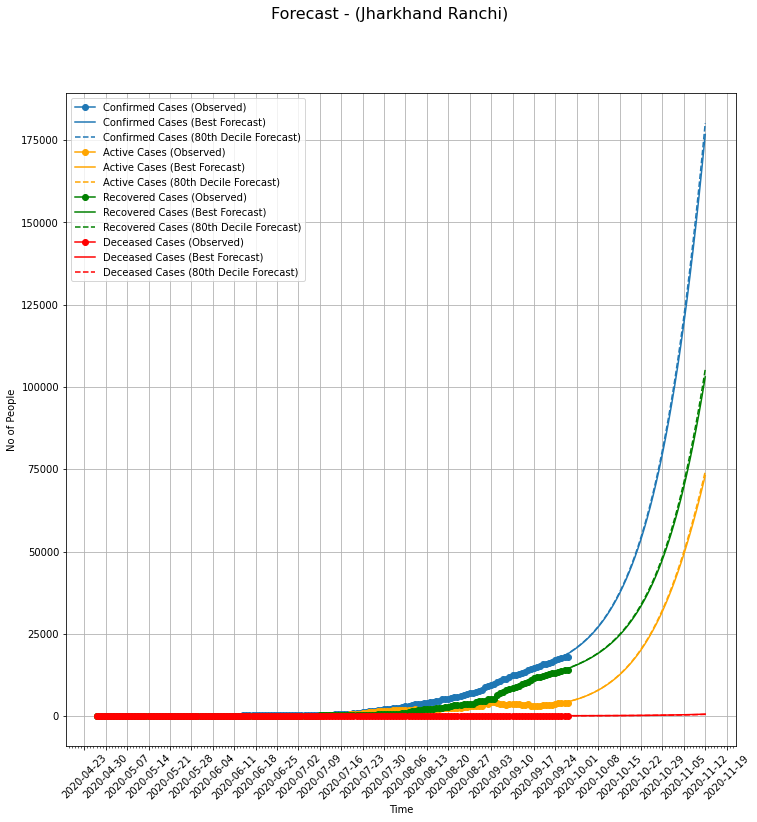

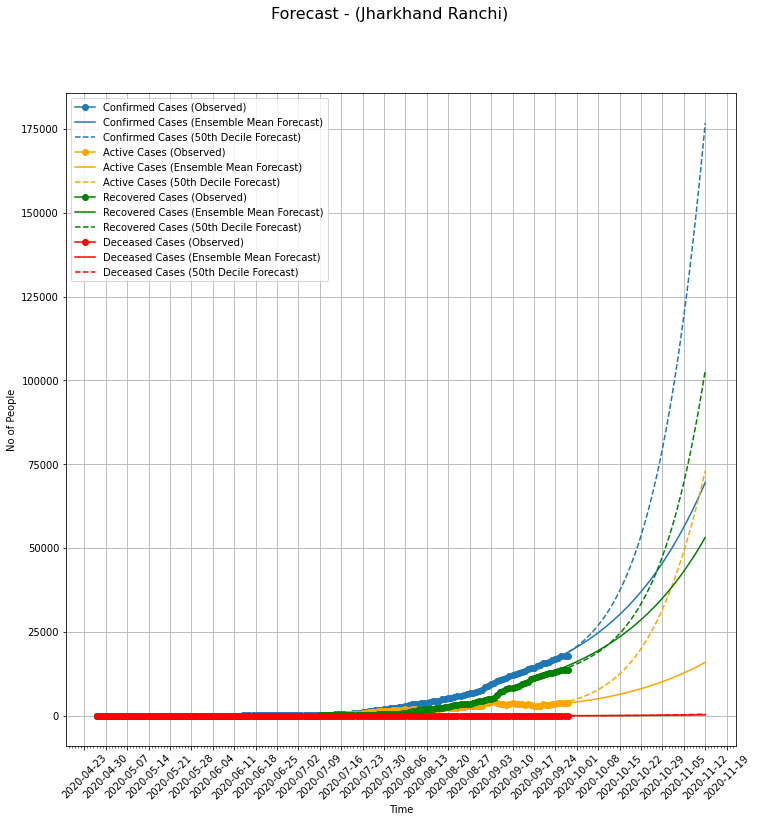

In [22]:
predictions_dict['m2']['plots']['forecast_best_50'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 50], error_bars=False)
predictions_dict['m2']['plots']['forecast_best_80'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 80], error_bars=False)
predictions_dict['m2']['plots']['forecast_ensemble_mean_50'] = plot_forecast(predictions_dict, 
                                                                             (config['fitting']['data']['dataloading_params']['state'], 
                                                                              config['fitting']['data']['dataloading_params']['district']),
                                                                             fits_to_plot=['ensemble_mean', 50], error_bars=False)

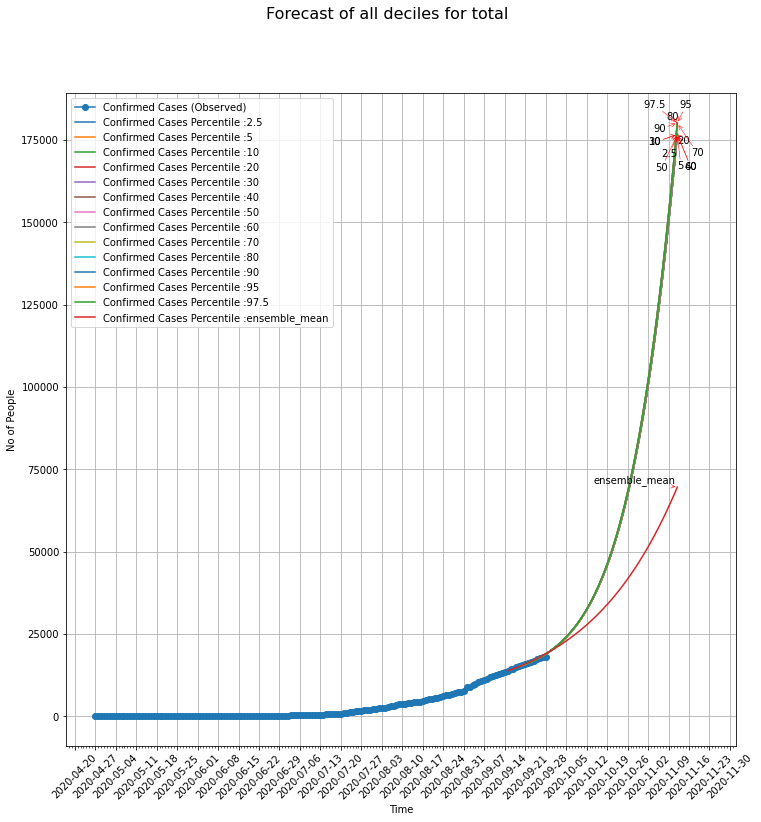

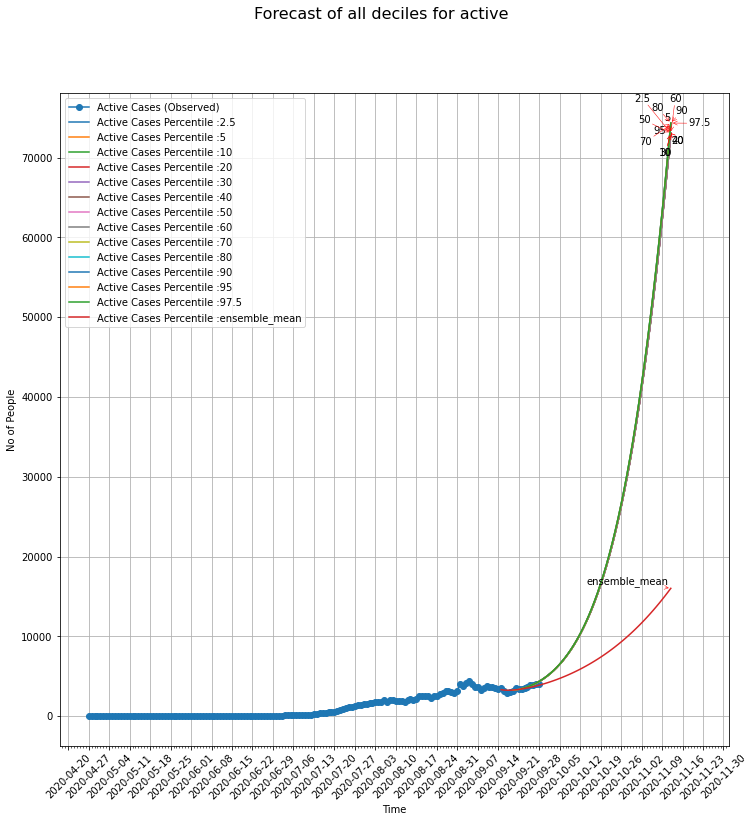

In [23]:
ptiles_plots = plot_ptiles(predictions_dict, which_compartments=config['forecast']['plot_ptiles_for_columns'])
predictions_dict['m2']['plots']['forecasts_ptiles'] = {}
for column in config['forecast']['plot_ptiles_for_columns']:
    predictions_dict['m2']['plots']['forecasts_ptiles'][column.name] = ptiles_plots[column]

## Create Report

In [24]:
save_dict_and_create_report(predictions_dict, config, ROOT_DIR=output_folder, config_filename=config_filename)

## Create Output

In [25]:
df_output = create_decile_csv_new(predictions_dict)
df_output.to_csv(f'{output_folder}/deciles.csv')

In [26]:
#log_wandb(predictions_dict)

## Create All Trials Output

In [27]:
df_all = create_all_trials_csv(predictions_dict)
df_all.to_csv(f'{output_folder}/all_trials.csv')

## Experiments

In [28]:
predictions_dict['m1'].keys()

dict_keys(['plots', 'best_params', 'default_params', 'variable_param_ranges', 'optimiser', 'df_prediction', 'df_district', 'df_train', 'df_val', 'df_loss', 'trials', 'data_last_date', 'df_district_unsmoothed', 'run_params', 'trials_processed'])